In [1]:
cat_set = "/content/cat"
dog_set = "/content/dog"

In [2]:
import os
import pandas as pd

# List the files in the directories
img_cat = [os.path.join(cat_set, file) for file in os.listdir(cat_set)[:1000]]
img_dog = [os.path.join(dog_set, file) for file in os.listdir(dog_set)[:1000]]

cat_df = pd.DataFrame({"image_path": img_cat, "Target": 1})
dog_df = pd.DataFrame({"image_path": img_dog, "Target": 0})
print(len(cat_df), len(dog_df))

1000 1000


In [3]:
# Concatenate the dataframes
cat_dog_df = pd.concat([cat_df, dog_df], ignore_index=True)

# Shuffle the combined dataframes
cat_dog_df = cat_dog_df.sample(frac=1).reset_index(drop=True)
cat_dog_df.head()

,image_path,Target
0,/content/dog/675.jpg,0
1,/content/dog/98.jpg,0
2,/content/cat/780.jpg,1
3,/content/dog/212.jpg,0
4,/content/cat/636.jpg,1


In [4]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
from skimage.filters import prewitt_h, prewitt_v
from skimage.morphology import closing, square
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Function to preprocess an image using HOG with fixed size
def resize_image(image_path, target_size):
    features_imag = []
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read the image in grayscale
    if img is None:
        print(f"Error: Unable to read image at {image_path}")
        return None

    # Resize the image to the target size
    img_resized = cv2.resize(img, target_size)
    return img_resized

def hog_features(img_resized, pixels_per_cell, cells_per_block):
    orientations=9
    # Ensure the image has at least 2 dimensions
    if len(img_resized.shape) < 2:
        return np.zeros((1, orientations * cells_per_block[0] * cells_per_block[1]))

    # Calculate the number of cells in the image
    n_cells_row = img_resized.shape[0] // pixels_per_cell[0]
    n_cells_col = img_resized.shape[1] // pixels_per_cell[1]

    # Calculate the size of the HOG block
    b_row = cells_per_block[0] * pixels_per_cell[0]
    b_col = cells_per_block[1] * pixels_per_cell[1]

    # Ensure the dimensions are not negative
    if n_cells_row <= 0 or n_cells_col <= 0 or b_row <= 0 or b_col <= 0:
        return np.zeros((1, orientations * cells_per_block[0] * cells_per_block[1]))

    # Compute HOG features
    hog_features = hog(img_resized,
                       orientations=orientations,
                       pixels_per_cell=pixels_per_cell,
                       cells_per_block=cells_per_block,
                       block_norm='L2-Hys',
                       visualize=False
                       )
    return hog_features

    # Function to apply Prewitt operator
def prewitt_operator(img_resized):
    # Apply Prewitt operator horizontally and vertically
    edges_horizontal = prewitt_h(img_resized)
    edges_vertical = prewitt_v(img_resized)
    # Combine horizontal and vertical edges
    edges = np.sqrt(edges_horizontal**2 + edges_vertical**2)
    return edges

# Function to apply morphological edge detection
def morphological_edge_detection(img_resized):
    # Apply morphological closing
    closed_image = closing(img_resized, square(3))
    # Compute edges by subtracting the closed image from the original
    edges = img_resized - closed_image
    return edges

# Perform best dimensional reduction PCA
def best_pca(X):
    pca = PCA()
    X_pca = pca.fit_transform(X)

    # Calculate explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_

    # Plot explained variance ratio
    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(explained_variance_ratio), marker='o', linestyle='-')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('Cumulative Explained Variance Ratio vs. Number of Components')
    plt.grid(True)
    plt.show()
    return

#perform best SVC
def best_svc(n_components, X_train, X_test, y_train, y_test):
    # Define the pipeline with a scaler, PCA, and SVC
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components)),
        ('svc', SVC())
    ])

    # Define the parameter grid
    param_grid = {
        'svc__C': [0.1, 1, 10, 100, 1000],  # Values for C
        'svc__gamma': [0.001, 0.01, 0.1, 1, 10]  # Values for gamma
    }

    # Perform grid search
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Print the best parameters and best score
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)

    # Evaluate the model on the test set
    accuracy = grid_search.score(X_test, y_test)
    print("Test Accuracy:", accuracy)
    return


#perform best Random Forest
def best_rf(X_train, X_test, y_train, y_test):
    # Define the parameter grid
    param_grid = {
            'n_estimators': [100, 250, 500],
            'max_depth': [None, 5, 10, 20],
            'criterion': ['gini', 'entropy']
            }

    # Instantiate the Random Forest classifier
    rf_classifier = RandomForestClassifier()

    # Instantiate GridSearchCV
    grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    # Perform grid search
    grid_search.fit(X_train, y_train)

    # Print the best parameters and best score
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)

    # Evaluate the model on the test set
    accuracy = grid_search.score(X_test, y_test)
    print("Test Accuracy:", accuracy)
    return



#perform best KNN
def best_knn(n_components, X_train, X_test, y_train, y_test):
    # Define the pipeline
    pipe_spm = Pipeline([
        ('scaler', StandardScaler()),  # Feature scaling
        ('pca', PCA(n_components)),  # Dimensionality reduction
        ('knn', KNeighborsClassifier())  # KNN
    ])
    # Define the parameter grid to search
    param_grid = {
    'knn__n_neighbors': [2, 3, 5, 7],  # Number of neighbors for kNN
    'knn__weights': ['uniform', 'distance']  # Weighting method for kNN
    }
    # Setup the grid search with cross-validation
    grid_search = GridSearchCV(pipe_spm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    # Perform the grid search on the training data
    grid_search.fit(X_train, y_train)

    # Get the best model
    best_pipeline = grid_search.best_estimator_

    # Print the best parameters found
    print("Best parameters:", grid_search.best_params_)

    # Evaluate the model on the test set
    accuracy = best_pipeline.score(X_test, y_test)
    print("Accuracy on the test set:", accuracy)
    return

In [5]:
size = (224, 224)
# Create a new column to store resized images
cat_dog_df['resized_image'] = cat_dog_df['image_path'].apply(lambda x: resize_image(x, size) if x else None)


pixels_per_cell = (8, 8)
cells_per_block = (2, 2)
# Create a new column to store HOG features
cat_dog_df['hog_features'] = cat_dog_df['resized_image'].apply(lambda x: hog_features(x, pixels_per_cell, cells_per_block) if x is not None and x.shape else None)

# Create a new column to store prewitt operator features
cat_dog_df['prewitt_features'] = cat_dog_df['resized_image'].apply(lambda x: prewitt_operator(x) if x is not None and x.shape else None)

# Create a new column to store morphological edge detection features
cat_dog_df['med_features'] = cat_dog_df['resized_image'].apply(lambda x: morphological_edge_detection(x) if x is not None and x.shape else None)

# Filter out rows with None values
filtered_cat_dog_df = cat_dog_df.dropna()


Error: Unable to read image at /content/cat/140.jpg
Error: Unable to read image at /content/cat/936.jpg
Error: Unable to read image at /content/cat/660.jpg
Error: Unable to read image at /content/cat/850.jpg


In [6]:
# Display the DataFrame with filtered feature
filtered_cat_dog_df.head()

,image_path,Target,resized_image,hog_features,prewitt_features,med_features
0,/content/dog/675.jpg,0,"[[151, 98, 97, 100, 104, 97, 100, 102, 100, 10...","[0.4130453435839935, 0.040181352455942586, 0.2...","[[0.3829619193714523, 0.4115073373493883, 0.37...","[[0, 254, 253, 0, 0, 251, 254, 0, 0, 0, 255, 2..."
1,/content/dog/98.jpg,0,"[[160, 149, 159, 158, 139, 151, 138, 146, 144,...","[0.11590306650132107, 0.22233000160522873, 0.2...","[[0.050762059709667004, 0.06578943546228293, 0...","[[241, 230, 235, 233, 209, 221, 202, 210, 208,..."
2,/content/cat/780.jpg,1,"[[254, 254, 254, 254, 254, 254, 254, 254, 254,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[1.1102230246251565e-16, 1.1102230246251565e-...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,/content/dog/212.jpg,0,"[[103, 130, 140, 123, 109, 95, 103, 103, 93, 1...","[0.1738659324353031, 0.12548142500574241, 0.05...","[[0.07900660515692327, 0.11923403138291643, 0....","[[229, 0, 0, 247, 233, 242, 0, 0, 246, 255, 0,..."
4,/content/cat/636.jpg,1,"[[60, 66, 65, 60, 60, 60, 60, 59, 58, 59, 60, ...","[0.28808054415723583, 0.109946656151989, 0.008...","[[0.024802177726810783, 0.021912489691817236, ...","[[250, 0, 0, 255, 255, 255, 255, 254, 253, 254..."


In [33]:
# Convert features column to a numpy array X
#med_features
#prewitt_features
#hog_features
X = np.array(filtered_cat_dog_df['hog_features'].tolist())
y = filtered_cat_dog_df["Target"]

# Reshape X to a 2D array
X = X.reshape(X.shape[0], -1)

# Display the shape of X and y
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1996, 26244)
y shape: (1996,)


Split the features (X) and target (y)

In [11]:
from sklearn.preprocessing import StandardScaler
ssc = StandardScaler()
X_scaled = ssc.fit_transform(X)

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X training:", X_train.shape)
print("X test:", X_test.shape)
print("y training:", y_train.shape)
print("y test:", y_test.shape)

X training: (1596, 26244)
X test: (400, 26244)
y training: (1596,)
y test: (400,)


Plot the best PCA according to X subset

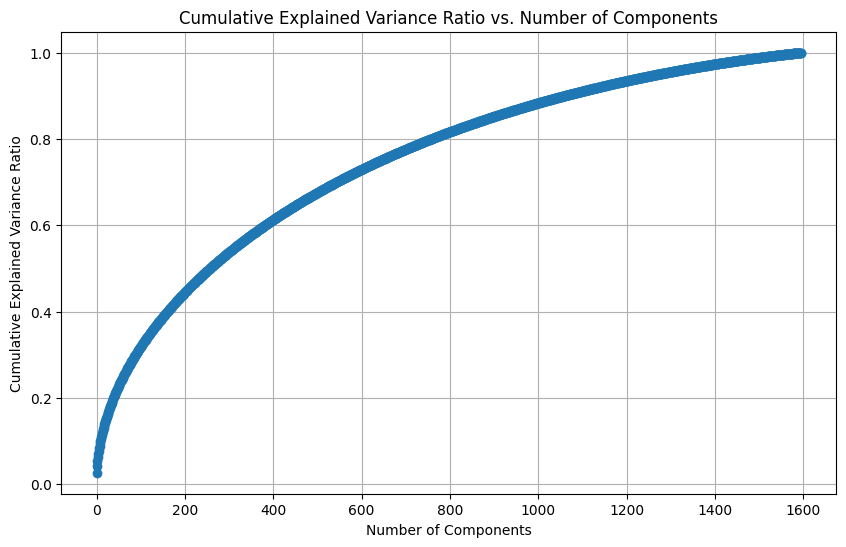

In [16]:
best_pca(X_train)

Perform grid research to get best parameters on SVC

In [35]:
n_components = 200

In [24]:
best_svc(n_components, X_train, X_test, y_train, y_test)

Best Parameters: {'svc__C': 100, 'svc__gamma': 0.001}
Best Score: 0.6240419278996865
Test Accuracy: 0.675


Perform grid research to get best parameters on RandomForest

In [31]:
best_rf(X_train, X_test, y_train, y_test)

Best Parameters: {'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 500}
Best Score: 0.712400078369906
Test Accuracy: 0.7225


Perform grid research to get best parameters on KNN

In [28]:
best_knn(n_components, X_train, X_test, y_train, y_test)

Best parameters: {'knn__n_neighbors': 2, 'knn__weights': 'distance'}
Accuracy on the test set: 0.6125


In [36]:
n_components = 200

# Define base classifiers with preprocessing
pipe_SVC = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_components)),
    ('svc', SVC(C=100.0, gamma=0.001, kernel='rbf'))
])

rf_classifier = RandomForestClassifier(n_estimators=500,
                                       max_depth=20,
                                       criterion='entropy')

pipe_knn = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('pca', PCA(n_components=n_components)),  # Dimensionality reduction
    ('knn', KNeighborsClassifier(n_neighbors=2, weights='distance'))  # KNN
])


Evaluating the model performance of each classifier via 10-fold cross-validation on the training dataset. hog_features

In [37]:
from sklearn.model_selection import cross_val_score

# Define the list of classifiers and their corresponding labels
classifiers = [pipe_SVC, rf_classifier, pipe_knn]
clf_labels = ['SVC', 'Random Forest', 'kNN']

# Perform 10-fold cross-validation for each classifier
for clf, label in zip(classifiers, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print(f'ROC AUC: {scores.mean():.2f} (+/- {scores.std():.2f}) [{label}]')


ROC AUC: 0.69 (+/- 0.05) [SVC]
ROC AUC: 0.77 (+/- 0.03) [Random Forest]
ROC AUC: 0.61 (+/- 0.03) [kNN]


Applying Gradient Boosting Classifier

In [39]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier


# Define the meta-classifier (Gradient Boosting Machine)
gbm = GradientBoostingClassifier()

# Create the stacking ensemble
estimators = [('svc', pipe_SVC), ('rf', rf_classifier), ('knn', pipe_knn)]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=gbm)

# Train the stacking classifier
stacking_clf.fit(X_train, y_train)

# Make predictions
y_pred = stacking_clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.63


In [40]:
from sklearn.ensemble import BaggingClassifier

# Create bagging classifiers for each base classifier
bagging_SVC = BaggingClassifier(estimator=pipe_SVC, n_estimators=10, random_state=42)
bagging_RF = BaggingClassifier(estimator=rf_classifier, n_estimators=10, random_state=42)
bagging_kNN = BaggingClassifier(estimator=pipe_knn, n_estimators=10, random_state=42)

# Train bagging classifiers
bagging_SVC.fit(X_train, y_train)
bagging_RF.fit(X_train, y_train)
bagging_kNN.fit(X_train, y_train)

# Make predictions
y_pred_SVC = bagging_SVC.predict(X_test)
y_pred_RF = bagging_RF.predict(X_test)
y_pred_kNN = bagging_kNN.predict(X_test)

# Calculate accuracy for each classifier
accuracy_SVC = accuracy_score(y_test, y_pred_SVC)
accuracy_RF = accuracy_score(y_test, y_pred_RF)
accuracy_kNN = accuracy_score(y_test, y_pred_kNN)

print("Accuracy for SVC Bagging:", accuracy_SVC)
print("Accuracy for RF Bagging:", accuracy_RF)
print("Accuracy for kNN Bagging:", accuracy_kNN)


Accuracy for SVC Bagging: 0.6175
Accuracy for RF Bagging: 0.6825
Accuracy for kNN Bagging: 0.595


Majority Voting

In [38]:
from sklearn.ensemble import VotingClassifier


# Create a voting classifier using majority voting
voting_clf = VotingClassifier(
    estimators=[('svc', pipe_SVC), ('rf', rf_classifier), ('knn', pipe_knn)],
    voting='hard'  # Use 'hard' voting for majority voting
)

# Train the voting classifier
voting_clf.fit(X_train, y_train)

# Make predictions
y_pred_voting = voting_clf.predict(X_test)

# Calculate accuracy
accuracy_voting = accuracy_score(y_test, y_pred_voting)
print("Accuracy using majority voting:", accuracy_voting)


Accuracy using majority voting: 0.6375


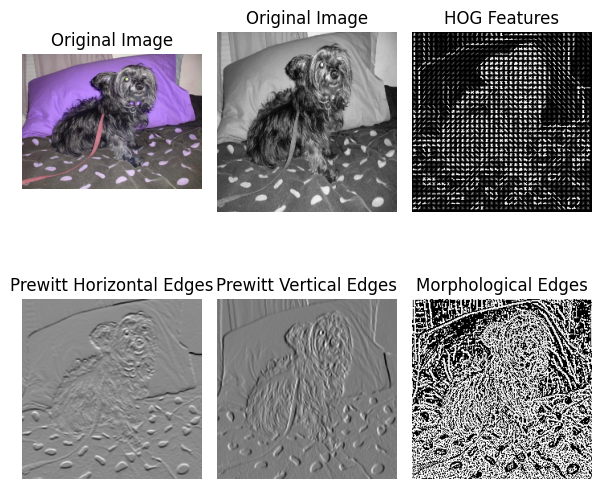

In [40]:
from skimage.filters import prewitt_h, prewitt_v
from skimage.morphology import closing, square
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure
import cv2

# read image
image = cv2.imread('/content/dog/0.jpg', cv2.IMREAD_GRAYSCALE)
image_color = cv2.imread('/content/dog/0.jpg')

# Resize image to  224x224
image_resized = cv2.resize(image, (224, 224))

# Apply HOG transformation
hog_features, hog_image = hog(image_resized, orientations=9, pixels_per_cell=(6, 6), cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)

# improve contraste
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

# Apply Prewitt operator horizontally and vertically
edges_horizontal = prewitt_h(image_resized)
edges_vertical = prewitt_v(image_resized)

# Combine horizontal and vertical edges
prewitt_edges = edges_horizontal + edges_vertical

# Apply morphological closing
closed_image = closing(image_resized, square(3))

# Compute edges by subtracting the closed image from the original
morphological_edges = image_resized - closed_image

# Create a subplot with 2 rows and 2 columns
fig, axes = plt.subplots(2, 3, figsize=(6, 6))

# Plot the original image
axes[0, 0].imshow(image_color)
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')

# Plot the original image gray scale
axes[0, 1].imshow(image_resized, cmap='gray')
axes[0, 1].set_title('Resized Image')
axes[0, 1].axis('off')

# Plot the HOG visualization
axes[0, 2].imshow(hog_image_rescaled, cmap='gray')
axes[0, 2].set_title('HOG Features')
axes[0, 2].axis('off')

# Plot the Prewitt edges
axes[1, 0].imshow(edges_horizontal, cmap='gray')
axes[1, 0].set_title('Prewitt Horizontal Edges')
axes[1, 0].axis('off')

axes[1, 1].imshow(edges_vertical, cmap='gray')
axes[1, 1].set_title('Prewitt Vertical Edges')
axes[1, 1].axis('off')

# Plot the morphological edges
axes[1, 2].imshow(morphological_edges, cmap='gray')
axes[1, 2].set_title('Morphological Edges')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()
